<a href="https://colab.research.google.com/github/LeoLiding/livingness_structure/blob/main/livingness_structure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyshp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Google Colab
import matplotlib.pyplot as plt

# 读取灰度图像
def read_grayscale_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # 计算平均灰度值
# def calculate_average_gray_value(image, mask=None):
#     if mask is None:
#         # For the first iteration, calculate the average gray value of the entire image
#         return np.mean(image)
#     else:
#         # For subsequent iterations, calculate the average gray value using the mask
#         # Convert mask to 8-bit unsigned integer
#         mask = mask.astype(np.uint8)
#         masked_image = cv2.bitwise_and(image, image, mask=mask)
#         masked_pixels = np.count_nonzero(mask)
#         if masked_pixels == 0:
#             return 0
#         return np.sum(masked_image) / masked_pixels

# 区分图形和地面
def distinguish_figure_ground(image, average_gray_value):
    height, width = image.shape
    figure = np.zeros_like(image, dtype=np.uint8)
    ground = np.zeros_like(image, dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            pixel_value = image[y, x]
            if pixel_value > average_gray_value:
                ground[y, x] = pixel_value
            else:
                figure[y, x] = pixel_value

    # Determine figure and ground based on the pixel counts
    dark_pixels_count = np.count_nonzero(figure)
    bright_pixels_count = np.count_nonzero(ground)
    #print(f"Number of dark_pixels_count: {dark_pixels_count}")
    #print(f"Number of bright_pixels_count: {bright_pixels_count}")
    if dark_pixels_count >= bright_pixels_count:
        return figure, ground, 2  # 2表示figure部分是暗像素
    else:
        return figure, ground, 1  # 1表示figure部分是亮像素


# # 周围8个像素判断
# def find_substructures(binary_image):
#     height, width = binary_image.shape
#     visited = np.zeros((height, width), dtype=bool)
#     substructures = []

#     for y in range(height):
#         for x in range(width):
#             if binary_image[y, x] == 255 and not visited[y, x]:
#                 substructure = set()
#                 stack = [(y, x)]

#                 while stack:
#                     current_y, current_x = stack.pop()
#                     visited[current_y, current_x] = True
#                     substructure.add((current_y, current_x))

#                     for dy in [-1, 0, 1]:
#                         for dx in [-1, 0, 1]:
#                             ny, nx = current_y + dy, current_x + dx
#                             if 0 <= ny < height and 0 <= nx < width and binary_image[ny, nx] == 255 and not visited[ny, nx]:
#                                 stack.append((ny, nx))

#                 substructures.append(substructure)

#     return substructures

# 周围4个像素判断
def find_substructures(binary_image):
    height, width = binary_image.shape
    visited = np.zeros((height, width), dtype=bool)
    substructures = []

    for y in range(height):
        for x in range(width):
            if binary_image[y, x] == 255 and not visited[y, x]:
                substructure = set()
                stack = [(y, x)]

                while stack:
                    current_y, current_x = stack.pop()
                    visited[current_y, current_x] = True
                    substructure.add((current_y, current_x))

                    for dy, dx in [(0, -1), (-1, 0), (0, 1), (1, 0)]:
                        ny, nx = current_y + dy, current_x + dx
                        if 0 <= ny < height and 0 <= nx < width and binary_image[ny, nx] == 255 and not visited[ny, nx]:
                            stack.append((ny, nx))

                substructures.append(substructure)

    return substructures


# # 在 distinguish2_figure_ground 函数中加入像素计数器
# def distinguish2_figure_ground(substructure_region, substructure_average_gray_value, bright_or_dark, contour_mask):
#     figure = np.zeros_like(substructure_region, dtype=np.uint8)
#     ground = np.zeros_like(substructure_region, dtype=np.uint8)
#     figure_pixels_count = 0
#     ground_pixels_count = 0

#     # Find the coordinates of non-zero (masked) pixels in the contour_mask
#     nonzero_pixels_y, nonzero_pixels_x = np.nonzero(contour_mask)

#     for y, x in zip(nonzero_pixels_y, nonzero_pixels_x):
#         pixel_value = substructure_region[y, x]

#         if bright_or_dark == 1:
#             # 如果figure部分是亮像素
#             if pixel_value > substructure_average_gray_value:
#                 ground[y, x] = pixel_value
#                 ground_pixels_count += 1
#             else:
#                 figure[y, x] = pixel_value
#                 figure_pixels_count += 1

#         elif bright_or_dark == 2:
#             # 如果figure部分是暗像素
#             if pixel_value > substructure_average_gray_value:
#                 figure[y, x] = pixel_value
#                 figure_pixels_count += 1
#             else:
#                 ground[y, x] = pixel_value
#                 ground_pixels_count += 1

#     return figure, ground, figure_pixels_count, ground_pixels_count


# 二值化图像
def binarize_image(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
    return binary_image

# head/tails breaks 子结构面积 返回断点
def segment_substructures_by_area_with_breakpoints(substructures):
    """
    Segments substructures based on their sizes (number of points),
    and returns the breakpoints.

    Params
    ------
    substructures : list of set
        List of substructure point sets.

    Returns
    -------
    breakpoints : list of float
        List of breakpoints.
    """
    # Test input
    assert substructures, "Input must not be empty."
    assert all(isinstance(substructure, set) for substructure in substructures), "All input values must be sets."

    breakpoints = []  # List to store breakpoints

    def htb_inner(substructures):
        """
        Inner ht breaks function for recursively computing the break points based on point sets.
        """
        # Add breakpoint to the list
        data_length = float(len(substructures))
        data_mean = sum(len(substructure) for substructure in substructures) / data_length
        breakpoints.append(data_mean)

        # Recursive call to get next break point
        head = [substructure for substructure in substructures if len(substructure) > data_mean]
        if len(head) > 1 and len(head) / data_length < 0.3:
            htb_inner(head)

    htb_inner(substructures)

    return breakpoints

# 周围4个像素判断
def find_substructures(binary_image):
    height, width = binary_image.shape
    visited = np.zeros((height, width), dtype=bool)
    substructures = []

    for y in range(height):
        for x in range(width):
            if binary_image[y, x] == 255 and not visited[y, x]:
                substructure = set()
                stack = [(y, x)]

                while stack:
                    current_y, current_x = stack.pop()
                    visited[current_y, current_x] = True
                    substructure.add((current_y, current_x))

                    for dy, dx in [(0, -1), (-1, 0), (0, 1), (1, 0)]:
                        ny, nx = current_y + dy, current_x + dx
                        if 0 <= ny < height and 0 <= nx < width and binary_image[ny, nx] == 255 and not visited[ny, nx]:
                            stack.append((ny, nx))

                substructures.append(substructure)

    return substructures



def calculate_image_vitality(num_breakpoints, num_substructures):
    vitality = (num_breakpoints + 1) * num_substructures
    return vitality




In [ ]:
# 区分图形和地面
def distinguish_figure_ground(image, average_gray_value):
    height, width = image.shape
    figure = np.zeros_like(image, dtype=np.uint8)
    ground = np.zeros_like(image, dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            pixel_value = image[y, x]
            if pixel_value > average_gray_value:
                ground[y, x] = pixel_value
            else:
                figure[y, x] = pixel_value

    # Determine figure and ground based on the pixel counts
    dark_pixels_count = np.count_nonzero(figure)
    bright_pixels_count = np.count_nonzero(ground)
    #print(f"Number of dark_pixels_count: {dark_pixels_count}")
    #print(f"Number of bright_pixels_count: {bright_pixels_count}")
    if dark_pixels_count >= bright_pixels_count:
        return figure, ground, 2  # 2表示figure部分是暗像素
    else:
        return figure, ground, 1  # 1表示figure部分是亮像素

# # 在 distinguish2_figure_ground 函数中加入像素计数器
# def distinguish2_figure_ground(substructure_region, substructure, substructure_average_gray_value, bright_or_dark):
#     figure = np.zeros_like(substructure_region, dtype=np.uint8)
#     ground = np.zeros_like(substructure_region, dtype=np.uint8)
#     figure_pixels_count = 0
#     ground_pixels_count = 0

#     pixel_values = [substructure_region[y, x] for y, x in substructure]
#     for pixel_value in pixel_values:
#         if bright_or_dark == 1:
#             # 如果figure部分是亮像素
#             if pixel_value > substructure_average_gray_value:
#                 ground[y, x] = pixel_value
#                 #ground_pixels_count += 1
#             else:
#                 figure[y, x] = pixel_value
#                 #figure_pixels_count += 1

#         elif bright_or_dark == 2:
#             # 如果figure部分是暗像素
#             if pixel_value > substructure_average_gray_value:
#                 figure[y, x] = pixel_value
#                #figure_pixels_count += 1
#             else:
#                 ground[y, x] = pixel_value
#                 #ground_pixels_count += 1
#     return figure, ground
#     # return figure, ground, figure_pixels_count, ground_pixels_count

# 在 distinguish2_figure_ground
def distinguish2_figure_ground(image, substructure, substructure_average_gray_value, bright_or_dark):
    figure = np.zeros_like(image, dtype=np.uint8)
    ground = np.zeros_like(image, dtype=np.uint8)
    # figure_pixels_count = 0
    # ground_pixels_count = 0

    for y, x in substructure:
        pixel_value = image[y, x]
        if bright_or_dark == 1:
            # 如果figure部分是亮像素
            if pixel_value > substructure_average_gray_value:
                ground[y, x] = pixel_value
                #ground_pixels_count += 1
            else:
                figure[y, x] = pixel_value
                #figure_pixels_count += 1

        elif bright_or_dark == 2:
            # 如果figure部分是暗像素
            if pixel_value > substructure_average_gray_value:
                figure[y, x] = pixel_value
                #figure_pixels_count += 1
            else:
                ground[y, x] = pixel_value
                #ground_pixels_count += 1

    return figure, ground



In [ ]:
import numpy as np

def calculate_average_gray_value(image, substructure=None):

    if substructure is None:
        return np.mean(image)

    # Calculate average gray value within the substructure
    gray_values = [image[y, x] for y, x in substructure]
    average_gray_value = sum(gray_values) / len(substructure)

    return average_gray_value


In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # # 计算平均灰度值
    # average_gray_value = calculate_average_gray_value(image)

    # 计算平均灰度值（整张图像）
    average_gray_value_image = calculate_average_gray_value(image)
    print("Average Gray Value of the Whole Image:", average_gray_value_image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value_image)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    # 创建一个与输入图像大小相同的空图像
    visualization = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)

    total_substructures_count = len(substructures)

    print(f"iteration 1: Total number of substructures in the initial vectorization: {total_substructures_count}")

    # 分割子结构并获取断点
    breakpoints = segment_substructures_by_area_with_breakpoints(substructures)
    print("Breakpoints:", breakpoints)
    print("hierarchy in iteration 1 is:", len(breakpoints)+1 )
    # 计算图像活力
    image_vitality = calculate_image_vitality(len(breakpoints), total_substructures_count)
    print("iteration 1: Image Vitality:", image_vitality)


Average Gray Value of the Whole Image: 163.70711233211233
Number of dark_pixels_count: 120036
Number of bright_pixels_count: 142044
iteration 1: Total number of substructures in the initial vectorization: 768
Breakpoints: [156.296875, 6841.941176470588, 51919.5]
hierarchy in iteration 1 is: 4
iteration 1: Image Vitality: 3072


In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # # 计算平均灰度值
    # average_gray_value = calculate_average_gray_value(image)

    # 计算平均灰度值（整张图像）
    average_gray_value_image = calculate_average_gray_value(image)
    print("Average Gray Value of the Whole Image:", average_gray_value_image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value_image)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    # 创建一个与输入图像大小相同的空图像
    visualization = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)

    total_substructures_count = len(substructures)

    print(f"iteration 1: Total number of substructures in the initial vectorization: {total_substructures_count}")

    # 分割子结构并获取断点
    breakpoints = segment_substructures_by_area_with_breakpoints(substructures)
    print("Breakpoints:", breakpoints)
    print("hierarchy in iteration 1 is:", len(breakpoints) + 1)
    # 计算图像活力
    image_vitality = calculate_image_vitality(len(breakpoints), total_substructures_count)
    print("iteration 1: Image Vitality:", image_vitality)

    # 统计可分解和不可分解的子结构
    decomposable_substructures = 0
    indivisible_substructures = 0

    print("Processing substructures:")
    for idx, substructure in enumerate(substructures):
        # 计算子结构的平均灰度值
        average_gray_value_substructure = sum(image[y, x] for y, x in substructure) / len(substructure)

        # 区分子结构图像和地面
        subfigure, subground = distinguish2_figure_ground(image, substructure, average_gray_value_substructure, bright_or_dark)

        # 二值化子结构图像
        binary_subimage = binarize_image(subfigure)

        # 提取子结构的子结构 这一步耗时太久了 可能需要想办法优化 比如并行处理 现在遍历100个要1分钟
        subsubstructures = find_substructures(binary_subimage)

        # 分割子结构并获取断点
        sub_breakpoints = segment_substructures_by_area_with_breakpoints(subsubstructures)

        # 判断是否可分解
        if len(sub_breakpoints) >= 2:
            decomposable_substructures += 1
        else:
            indivisible_substructures += 1

        # 每遍历50个子结构打印信息
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1} substructures...")
            print("Decomposable Substructures:", decomposable_substructures)
            print("Indivisible Substructures:", indivisible_substructures)

    print("Decomposable Substructures:", decomposable_substructures)
    print("Indivisible Substructures:", indivisible_substructures)


Average Gray Value of the Whole Image: 163.70711233211233
iteration 1: Total number of substructures in the initial vectorization: 768
Breakpoints: [156.296875, 6841.941176470588, 51919.5]
hierarchy in iteration 1 is: 4
iteration 1: Image Vitality: 3072
Processing substructures:
Processed 50 substructures...
Decomposable Substructures: 4
Indivisible Substructures: 46
Processed 100 substructures...
Decomposable Substructures: 6
Indivisible Substructures: 94
Processed 150 substructures...
Decomposable Substructures: 7
Indivisible Substructures: 143
Processed 200 substructures...
Decomposable Substructures: 7
Indivisible Substructures: 193
Processed 250 substructures...
Decomposable Substructures: 7
Indivisible Substructures: 243
Processed 300 substructures...
Decomposable Substructures: 7
Indivisible Substructures: 293
Processed 350 substructures...
Decomposable Substructures: 7
Indivisible Substructures: 343
Processed 400 substructures...
Decomposable Substructures: 8
Indivisible Substr

In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # 计算平均灰度值（整张图像）
    average_gray_value_image = calculate_average_gray_value(image)
    print("Average Gray Value of the Whole Image:", average_gray_value_image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value_image)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    # 创建一个与输入图像大小相同的空图像
    visualization = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)

    total_substructures_count = len(substructures)

    print(f"iteration 1: Total number of substructures in the initial vectorization: {total_substructures_count}")

    # 分割子结构并获取断点
    breakpoints = segment_substructures_by_area_with_breakpoints(substructures)
    print("Breakpoints:", breakpoints)
    print("hierarchy in iteration 1 is:", len(breakpoints) + 1)
    # 计算图像活力
    image_vitality = calculate_image_vitality(len(breakpoints), total_substructures_count)
    print("iteration 1: Image Vitality:", image_vitality)

    total_image_vitality = image_vitality  # 总图像活力

    iteration = 2
    while True:
        print(f"Iteration {iteration}:")
        print("Processing substructures:")
        new_substructures = []
        decomposable_substructures = 0
        indivisible_substructures = 0
        substructures_image_vitality = 0

        for substructure in substructures:
            # 计算子结构的平均灰度值
            average_gray_value_substructure = sum(image[y, x] for y, x in substructure) / len(substructure)

            # 区分子结构图像和地面
            subfigure, subground = distinguish2_figure_ground(image, substructure, average_gray_value_substructure, bright_or_dark)

            # 二值化子结构图像
            binary_subimage = binarize_image(subfigure)

            # 提取子结构的子结构
            subsubstructures = find_substructures(binary_subimage)

            # 分割子结构并获取断点
            sub_breakpoints = segment_substructures_by_area_with_breakpoints(subsubstructures)

            # 判断是否可分解
            if len(sub_breakpoints) >= 2:
                decomposable_substructures += 1
                new_substructures.extend(subsubstructures)

                # 计算可分解子结构的图像活力
                substructure_image_vitality = calculate_image_vitality(len(sub_breakpoints), len(subsubstructures))
                substructures_image_vitality += substructure_image_vitality
            else:
                indivisible_substructures += 1

        total_image_vitality += substructures_image_vitality  # 累加总图像活力
        print("Decomposable Substructures:", decomposable_substructures)
        print("Indivisible Substructures:", indivisible_substructures)
        print("Substructures Image Vitality:", substructures_image_vitality)

        if decomposable_substructures == 0:
            break

        substructures = new_substructures
        iteration += 1

    print("Total Image Vitality:", total_image_vitality)


Average Gray Value of the Whole Image: 163.70711233211233
iteration 1: Total number of substructures in the initial vectorization: 768
Breakpoints: [156.296875, 6841.941176470588, 51919.5]
hierarchy in iteration 1 is: 4
iteration 1: Image Vitality: 3072
Iteration 2:
Processing substructures:
Decomposable Substructures: 11
Indivisible Substructures: 757
Substructures Image Vitality: 7264
Iteration 3:
Processing substructures:
Decomposable Substructures: 20
Indivisible Substructures: 1836
Substructures Image Vitality: 4413
Iteration 4:
Processing substructures:
Decomposable Substructures: 20
Indivisible Substructures: 1178
Substructures Image Vitality: 1764
Iteration 5:
Processing substructures:
Decomposable Substructures: 4
Indivisible Substructures: 558
Substructures Image Vitality: 335
Iteration 6:
Processing substructures:
Decomposable Substructures: 2
Indivisible Substructures: 95
Substructures Image Vitality: 51
Iteration 7:
Processing substructures:
Decomposable Substructures: 0
I

**可视化**

Number of dark_pixels_count: 120036
Number of bright_pixels_count: 142044
iteration 1: Total number of substructures in the initial vectorization: 768
Breakpoints: [156.296875, 6841.941176470588, 51919.5]
hierarchy in iteration 1 is: 4
iteration 1: Image Vitality: 3072


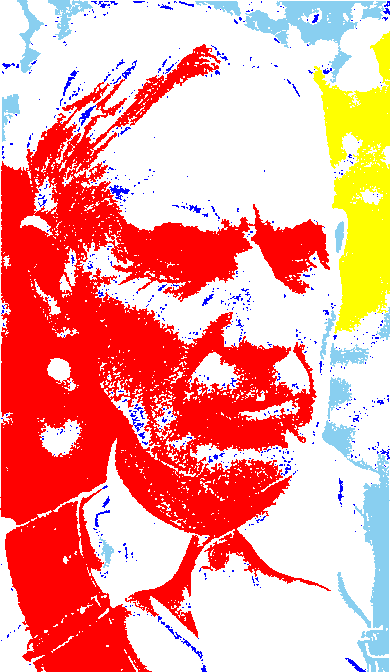

In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # 计算平均灰度值
    average_gray_value = calculate_average_gray_value(image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    # 创建一个与输入图像大小相同的空图像
    visualization = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)

    total_substructures_count = len(substructures)

    print(f"iteration 1: Total number of substructures in the initial vectorization: {total_substructures_count}")

    # 分割子结构并获取断点
    breakpoints = segment_substructures_by_area_with_breakpoints(substructures)
    print("Breakpoints:", breakpoints)
    print("hierarchy in iteration 1 is:", len(breakpoints)+1 )
    # 计算图像活力
    image_vitality = calculate_image_vitality(len(breakpoints), total_substructures_count)
    print("iteration 1: Image Vitality:", image_vitality)


    # 设置不同颜色 B G R
    colors = [(255, 1, 1), (240, 207, 137), (1, 255, 255), (1, 1, 255)]

    # 根据断点可视化不同部分的子结构
    for idx, substructure in enumerate(substructures):
        for y, x in substructure:
            area = len(substructure)

            if area > breakpoints[2]:
                color = colors[3]  # 红色
            elif area > breakpoints[1]:
                color = colors[2]  # 黄色
            elif area > breakpoints[0]:
                color = colors[1]  # 浅蓝色
            else:
                color = colors[0]  # 深蓝色

            visualization[y, x] = color
    # 将可视化图像中的黑色部分替换为白色 改下上面配色还要，这一步把0的全改了
    visualization[visualization[:, :, 0] == 0] = 255
    visualization[visualization[:, :, 1] == 0] = 255
    visualization[visualization[:, :, 2] == 0] = 255
    cv2_imshow(visualization)


In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # 计算平均灰度值
    average_gray_value = calculate_average_gray_value(image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    # # 分割子结构为头部和尾部，使用40%的子结构最大面积作为阈值
    # threshold_ratio = 0.4
    # head_substructures, tail_substructures = segment_substructures(substructures, threshold_ratio)

    # 分割子结构为头部和尾部，使用40%的子结构最大面积作为阈值
    segmented_substructures, break_points = segment_substructures(substructures)

    # 打印头部子结构中的断点数量
    print("Number of breakpoints in head substructures:", break_points)

    # 分割后的子结构
    head_substructures = segmented_substructures[0]
    tail_substructures = segmented_substructures[1]

    # Print the results
    print("Hierarchy 1 (Head):")
    print(f"Number of head substructures: {len(head_substructures)}")

    print("Hierarchy 1 (Tail):")
    print(f"Number of tail substructures: {len(tail_substructures)}")

    total_substructures_count = len(substructures)

    print("iteration 1 hierarchy 1")
    print(f"Total number of substructures in the initial vectorization: {total_substructures_count}")


Number of dark_pixels_count: 120036
Number of bright_pixels_count: 142044
Number of breakpoints in head substructures: 2
Hierarchy 1 (Head):
Number of head substructures: 246
Hierarchy 1 (Tail):
Number of tail substructures: 3
iteration 1 hierarchy 1
Total number of substructures in the initial vectorization: 768


In [ ]:
if __name__ == "__main__":
    # 读取灰度图像
    image_path = "P5a.png"
    image = read_grayscale_image(image_path)

    # 计算平均灰度值
    average_gray_value = calculate_average_gray_value(image)

    # 区分图形和地面
    figure, ground, bright_or_dark = distinguish_figure_ground(image, average_gray_value)

    # 二值化图像
    binary_image = binarize_image(figure)  # Use figure as it contains the structures

    # 提取子结构
    substructures = find_substructures(binary_image)

    total_substructures_count = len(substructures)
    hierarchy = 1

    while True:
        # 分割子结构为头部和尾部，使用40%的子结构最大面积作为阈值
        threshold_ratio = 0.4
        head_substructures, tail_substructures = segment_substructures(substructures, threshold_ratio)

        # Print the results for this hierarchy
        print(f"hierarchy {hierarchy} (Head):")
        print(f"Number of head substructures: {len(head_substructures)}")

        print(f"hierarchy {hierarchy} (Tail):")
        print(f"Number of tail substructures: {len(tail_substructures)}")

        hierarchy += 1

        # Check if the tail substructures meet the stop condition (pixel count <= 3)
        stop = True
        new_substructures = []

        for contour in tail_substructures:
            if cv2.contourArea(contour) > 3:
                stop = False
                new_substructures.append(contour)

        if stop:
            break

        substructures = tail_substructures

    print("Finished segmenting substructures.")


Number of dark_pixels_count: 120036
Number of bright_pixels_count: 142044
hierarchy 1 (Head):
Number of head substructures: 1
hierarchy 1 (Tail):
Number of tail substructures: 767
hierarchy 2 (Head):
Number of head substructures: 1
hierarchy 2 (Tail):
Number of tail substructures: 766
hierarchy 3 (Head):
Number of head substructures: 2
hierarchy 3 (Tail):
Number of tail substructures: 764
hierarchy 4 (Head):
Number of head substructures: 2
hierarchy 4 (Tail):
Number of tail substructures: 762
hierarchy 5 (Head):
Number of head substructures: 1
hierarchy 5 (Tail):
Number of tail substructures: 761
hierarchy 6 (Head):
Number of head substructures: 5
hierarchy 6 (Tail):
Number of tail substructures: 756
hierarchy 7 (Head):
Number of head substructures: 4
hierarchy 7 (Tail):
Number of tail substructures: 752
hierarchy 8 (Head):
Number of head substructures: 6
hierarchy 8 (Tail):
Number of tail substructures: 746
hierarchy 9 (Head):
Number of head substructures: 17
hierarchy 9 (Tail):
Numbe